In [113]:
import pandas as pd
import numpy as np

In [187]:
def hkl_gen(x): 
    """ x is range"""
    df = pd.DataFrame(columns=["h", "k", "l"])
    for h in range(-x, x + 1): 
        for k in range(-x, x  + 1): 
            for l in range(-x, x + 1): 
                idx = len(df)
                df.loc[idx, "h"] = h
                df.loc[idx, "k"] = k
                df.loc[idx, "l"] = l
    return df


In [188]:
def compute_d(x):
    """1/d^2  cubic """
    h, k, l = x
    return (h ** 2 + k ** 2 + l ** 2) / a ** 2 



In [509]:
def compute_zone_axis(x, axis=[1,1,1]):
    h, k, l = x
    a, b, c = axis
    buff = h * a + k * b + l * c
    if buff == 0 :
        if forbidden(x): 
            return True
    return False

def forbidden(x): 
    """
    fcc cubic 
    """
    h, k, l = x
    if not h%2 and  not k%2 and  not l%2: 
        return True
    elif (h%2 and k%2 and l%2): 
        return True
    return False

def compute_angles(dft): 
    def calc_theta(x, h2, k2, l2):
        h1, k1, l1, = x
        num = round(h1 * h2 + k1 * k2 + l1 * l2 , 3)
        denom = np.sqrt(h1 **2 + k1 ** 2 + l1 ** 2) * np.sqrt(h2 ** 2 + k2 ** 2 + l2 ** 2)
        buff = np.arccos(num / denom) 
        if np.isnan(buff): 
            a = 1 if num/denom > 0 else -1
            buff = np.arccos(a)
        return buff
    
    dft = dft[dft['1/d2'] != 0]
    buff = dft.copy()
    
    buff = buff[(buff["h"] >= 0) & (buff["k"] >= 0) & (buff["l"] >= 0)]
    if buff.empty: 
        buff = dft.copy()
    h_ref, k_ref, l_ref, d_ref = tuple(buff[buff["1/d2"] == buff["1/d2"].min()][["h", "k", "l", "d"]].values[0])
    dft["angle"] = dft[["h", "k", "l"]].apply(lambda x: calc_theta(x, h_ref, k_ref, l_ref), raw=True, axis=1)
    dft["distance"] = dft[["d"]].apply(lambda x:  round(d_ref / x[0], 4), raw=True, axis=1)
    dft["x"] = round(dft["distance"] * np.cos(dft["angle"]), 4)
    dft["y"] = round(dft["distance"] * np.sin(dft["angle"]), 4)
    # Negative Angle 
    buff = dft.copy()
    buff["x"] = round(dft["distance"] * np.cos(-dft["angle"]), 4)
    buff["y"] = round(dft["distance"] * np.sin(-dft["angle"]), 4)
    return pd.concat([dft, buff], axis = 0).reset_index(drop=True)


def plot_data(dft): 
    dft.loc[len(df), ["h", "k", "l", "x", "y"]] = (0,0,0,0,0)
    # dft = dft.sort_values(["h", "k", "l"]).drop_duplicates(subset=["x", "y"], keep="first")
    
    dft["theta"] = np.arctan(dft.y/dft.x)
    dft.reset_index(drop=True, inplace=True)
    for i in dft.index: 
        buff = dft.loc[i, "x"]
        if buff < 0: 
            dft.loc[i, "theta"] += np.pi
    dft["theta"] = round(dft["theta"], 5)
    dft["r"] = round(np.sqrt(dft.x ** 2 + dft.y ** 2), 5)
    dft = dft.fillna(0)
    
    dft = dft.sort_values(["h", "k", "l"])
    dft = dft.drop_duplicates(subset=["theta", "r"], keep="last")

    fig = plt.figure(figsize=(15,15))

    ax = fig.add_subplot(111, projection='polar')
    c = ax.scatter(dft.theta, dft.r, s=1000, color="grey")

    for i in dft.index: 
        h = dft.loc[i, "h"]
        k = dft.loc[i, "k"]
        l = dft.loc[i, "l"]
        theta= dft.loc[i, "theta"]
        r = dft.loc[i, "r"]
        ax.text(theta, r, f"{h}{k}{l}", horizontalalignment='center')
    return plt, dft

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

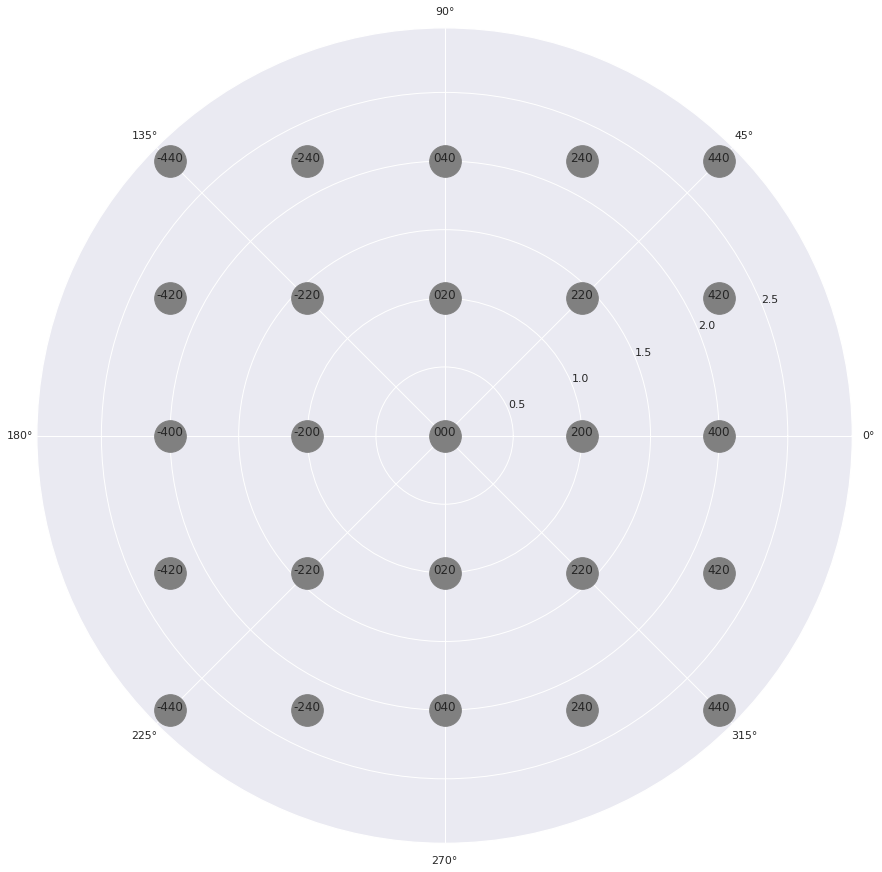

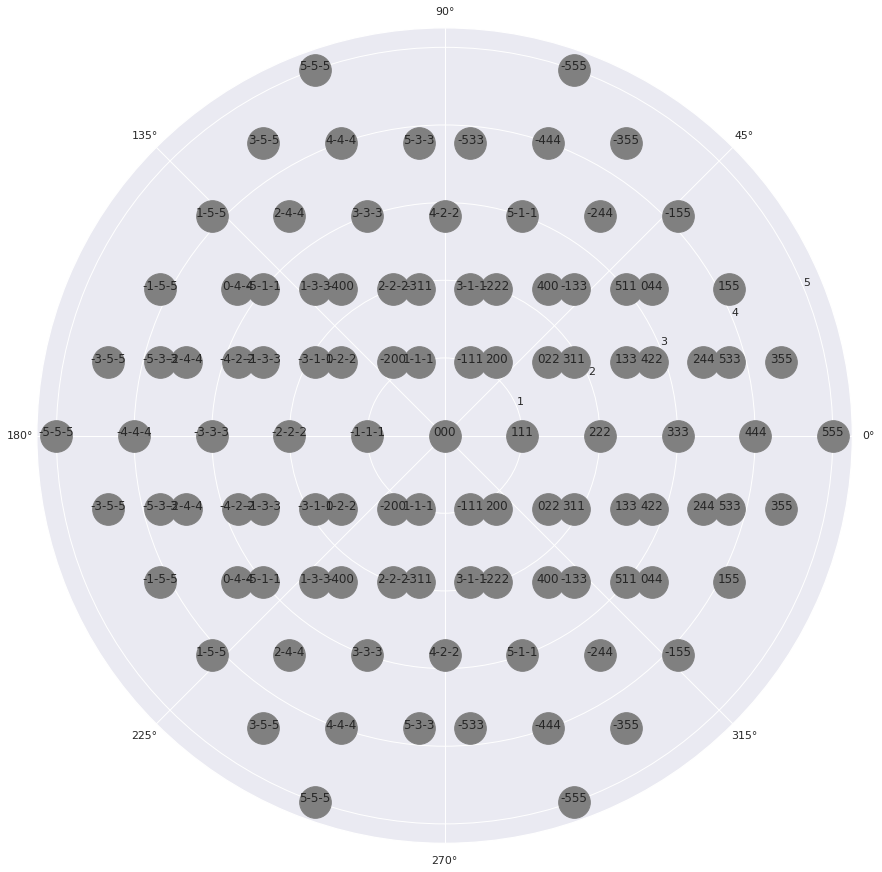

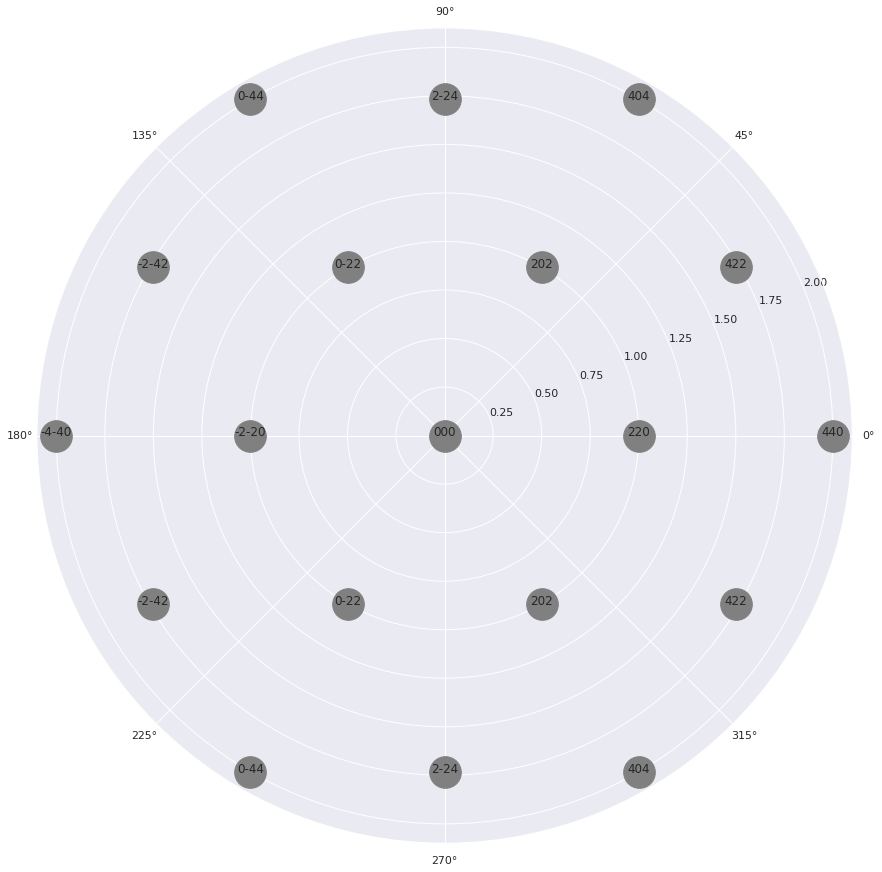

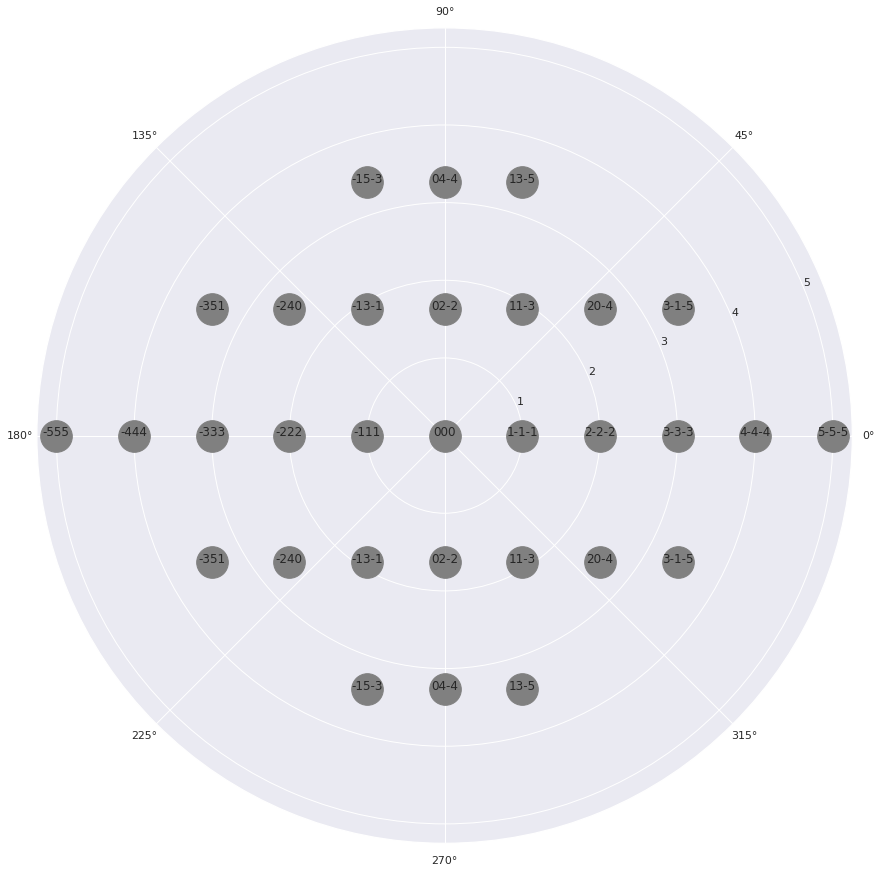

In [511]:
a = b = c = .4611 # nm
alpha = beta = gamma = 60 * 2 * np.pi / 360 # Angles
c = .4234

df  = hkl_gen(5)
    
df["1/d2"] = df[["h", "k", "l"]].apply(compute_d, raw=True, axis=1)
df["d"] = 1/(df["1/d2"] ** .5 )

axis = [(0, 0, 1), (0, -1, 1),(1, -1, -1), (2, 1,1)  ]
names = ["001", "0_11", "1_1_1", "211"]
for i in range(4): 
    a = axis[i]
    n = names[i]
    df[f"{a}"] = df[["h", "k", "l"]].apply(lambda x: compute_zone_axis(x, a), raw=True, axis=1)
    dft = df[df[f"{a}"]]
    dft = dft.sort_values(["d", "h", "k", "l"], ascending=False).reset_index(drop=True)
    dft = compute_angles(dft)

    plt, dft = plot_data(dft)
    
    plt.savefig(f"./Problem1/{n}.png")
    dft.to_csv(f"./Problem1/{n}.csv")

# for i in range(4): 
#     a = axis[i]
#     n = names[i]
#     df[f"{a}"] = df[["h", "k", "l"]].apply(lambda x: compute_zone_axis(x, a), raw=True, axis=1)
# dft = df[df[f"{axis[3]}"]]
# dft = dft.sort_values(["d", "h", "k", "l"], ascending=False).reset_index(drop=True)
# dft = compute_angles(dft)

In [ ]:
import matplotlib.pyplot as plt
dft.loc[len(df), ["h", "k", "l", "x", "y"]] = (0,0,0,0,0)
dft = dft.sort_values(["h", "k", "l"]).drop_duplicates(subset=["x", "y"], keep="first")

plt.figure(figsize=(15,15))
for i in dft.index: 
    h = dft.loc[i, "h"]
    k = dft.loc[i, "k"]
    l = dft.loc[i, "l"]
    x = dft.loc[i, "x"]
    y = dft.loc[i, "y"]
    plt.scatter([x], [y], s=1000, color="grey")
    plt.text(x, y-.25, f"{h}{k}{l}", horizontalalignment='center')

plt.axis('off')

In [504]:
dft["theta"] = np.arctan(dft.y/dft.x)
dft.reset_index(drop=True, inplace=True)
for i in dft.index: 
    buff = dft.loc[i, "x"]
    if buff < 0: 
        dft.loc[i, "theta"] += np.pi

dft["r"] = np.sqrt(dft.x ** 2 + dft.y ** 2)
dft = dft.fillna(0)

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(dft.theta, dft.r, s=1000, color="grey")

for i in dft.index: 
    h = dft.loc[i, "h"]
    k = dft.loc[i, "k"]
    l = dft.loc[i, "l"]
    theta= dft.loc[i, "theta"]
    r = dft.loc[i, "r"]
    ax.text(theta, r, f"{h}{k}{l}", horizontalalignment='center')

AttributeError: 'DataFrame' object has no attribute 'y'

    h  k  l        1/d2         d (0, 0, 1) (0, -1, 1) (1, -1, -1) (2, 1, 1)     angle  distance       x       y     theta         r
0  -3 -3 -3  126.991169  0.088739     False       True       False     False  3.141593    3.0000 -3.0000  0.0000  3.141593  3.000000
1  -3 -1 -1   51.737143  0.139027     False       True       False     False  2.626787    1.9149 -1.6667  0.9428  2.626799  1.914879
2  -3 -1 -1   51.737143  0.139027     False       True       False     False  2.626787    1.9149 -1.6667 -0.9428  3.656386  1.914879
3  -3  1  1   51.737143  0.139027     False       True       False     False  1.745765    1.9149 -0.3333  1.8857  1.745741  1.914929
4  -3  1  1   51.737143  0.139027     False       True       False     False  1.745765    1.9149 -0.3333 -1.8857  4.537445  1.914929
5  -3  3  3  126.991169  0.088739     False       True       False      True  1.230959    3.0000  1.0000  2.8284  1.230956  2.999974
6  -3  3  3  126.991169  0.088739     False       True       False   

,h,k,l,1/d2,d,"(0, 0, 1)","(0, -1, 1)","(1, -1, -1)","(2, 1, 1)",angle,distance,x,y,theta,r
0,-3,-3,-3,126.991169,0.088739,False,True,False,False,3.141593,3.0000,-3.0000,0.0000,-0.000000,3.000000
1,-3,-1,-1,51.737143,0.139027,False,True,False,False,2.626787,1.9149,-1.6667,0.9428,-0.514793,1.914879
2,-3,-1,-1,51.737143,0.139027,False,True,False,False,2.626787,1.9149,-1.6667,-0.9428,0.514793,1.914879
3,-3,1,1,51.737143,0.139027,False,True,False,False,1.745765,1.9149,-0.3333,1.8857,-1.395852,1.914929
4,-3,1,1,51.737143,0.139027,False,True,False,False,1.745765,1.9149,-0.3333,-1.8857,1.395852,1.914929
5,-3,3,3,126.991169,0.088739,False,True,False,True,1.230959,3.0000,1.0000,2.8284,1.230956,2.999974
6,-3,3,3,126.991169,0.088739,False,True,False,True,1.230959,3.0000,1.0000,-2.8284,-1.230956,2.999974
7,-2,-2,-2,56.440519,0.133108,False,True,False,False,3.141593,2.0000,-2.0000,0.0000,-0.000000,2.000000
8,-2,0,0,18.813506,0.230550,True,True,False,False,2.186276,1.1547,-0.6667,0.9428,-0.955289,1.154712
9,-2,0,0,18.813506,0.230550,True,True,False,False,2.186276,1.1547,-0.6667,-0.9428,0.955289,1.154712
